<a href="https://colab.research.google.com/github/chirag2saraiya/TSAI-DeepVision-EVA4/blob/master/02-Transferlearning-Mobilenet/Sessionp2s2_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libs

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD 
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

# Fetch Data

In [3]:
!unzip -q /content/drive/My\ Drive/p2s2Data/Session2_Dataset_cleaned.zip -d ./

In [ ]:
import os

dir_name = "/content/Session2_Dataset_cleaned/Winged Drones"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".png"):
      print(item)
      os.remove(os.path.join(dir_name, item))

In [2]:
# Clone github repo containing the utility functions
!git clone https://github.com/chirag2saraiya/TSAI-DeepVision-EVA4.git

Cloning into 'TSAI-DeepVision-EVA4'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 184 (delta 106), reused 60 (delta 23), pack-reused 0
Receiving objects: 100% (184/184), 1.94 MiB | 2.05 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [3]:
%cd TSAI-DeepVision-EVA4/02-Transferlearning-Mobilenet/

/content/TSAI-DeepVision-EVA4/02-Transferlearning-Mobilenet


In [ ]:
# split data into training and validation sets in ration 70:30
from utils.split_data import *
split_data_folder('/content/Session2_Dataset_cleaned/', '/content/data', 0.7)

We have 4 classes in our dataset. The dataset has been split into train(70%) and val(30%) folders. Under these folders data is stored in separate folders according to the classes. The architecture of the folders is as below:

```
/datadir
    /train
            /Flying Birds
            /Large QuadCopters
            /Small QuadCopters
            /Winged Drones
    /val
            /Flying Birds
            /Large QuadCopters
            /Small QuadCopters
            /Winged Drones
```


In [4]:
# Generate classwise summary of Dataset

from model.model import *
from model.train import *
from utils.transform import *

data_transform = DataClass("/content/data/")

train_dir,valid_dir = data_transform.get_data_path()
data_transform.show_number_of_data_in_class()


             Classes  n_train  n_valid  n_total
0  Small QuadCopters     2676     1148     3824
1      Winged Drones     3173     1360     4533
2  Large QuadCopters     2741     1176     3917
3       Flying Birds     4497     1928     6425


# Data Preprocessing


### Data Augmentation  
In order to emulate larger dataset for training we apply various image tranformations. 
- Random Crop
- Random Rotation
- Random Horizontal Flips
- Colour Jitter

These transformations are randomly applied on the fly during the training.


## Data Preparation
In order for pytorch model to ingest the data it must be in proper form thus we apply following transformations to train as well as validation data  
- Center Crop 224x224 (required by the pretrained MobilNetV2 Model)
- Convert to Torch Tensor
- Image Normalization 


It must be noted that if input image is PIL RGB image transform.ToTensor() implicitly rearranges input image channels from (HxWxC) to (CxHxW) also scales it to range of [0,1.0].

In [5]:
# Generate training and validation data loaders
image_transform = data_transform.get_image_transform()
dataloader_train ,dataloader_valid = data_transform.get_dataloader(batch_size=128)


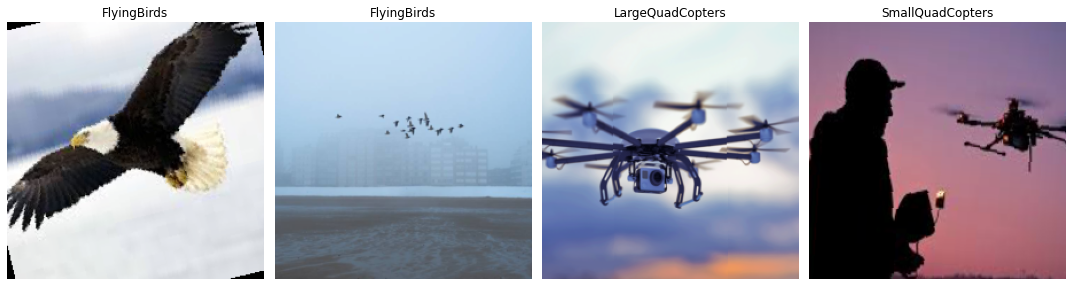

In [ ]:
# Show examples of kind of data transforms applied

class_names = ['FlyingBirds','LargeQuadCopters','SmallQuadCopters','WingedDrones']
data_transform = data_transform.image_show(class_names, 4, 1, 4, dataloader_train)

# Model Design

We will be using pretrained MobileNetV2 model available in PyTorch.
This model has been trained on Imagenet which consists of millions of images across 1000 categories. We will freeze the early layers and replace the classification module with our own and train on our own dataset. 

## Approach

We will be following below approach
1. Load pre-trained weights for MobileNetV2 model trained on Imagenet dataset

2. Freeze the layers appearing earlier in the model (mostly convolution layers
3. Replace the classifier (fully connected) part of the network with a custom classifier such that number of outputs are equal to number of classes in our dataset
4. Train the customized model on our dataset

In [7]:
# Get customized MobileNetV2 model with pretrained weights for ImageNet dataset
model = get_pretrained_model('mobilenet_v2')

# Get Training optimizer and loss criterion
criterion, optimizer = get_optimiser(model)
scheduler = get_scheduler(optimizer)

# Set file_name where intermediate models will be saved
save_file_name = '/content/mobilenet_v2-transfer-4.pt'

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


# Training

We train the model for 20 epochs with batch_size of 128 and SGD optimizer and step_lr scheduler

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloader_train,
    dataloader_valid,
    save_file_name,
    scheduler,
    max_epochs_stop=5,
    n_epochs = 20
    )


  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 1.0820 Acc: 0.5576


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.7588 Acc: 0.7750
Epoch 1/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.6784 Acc: 0.7635


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.5458 Acc: 0.8196
Epoch 2/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.5513 Acc: 0.7931


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4746 Acc: 0.8226
Epoch 3/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4993 Acc: 0.8064


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4396 Acc: 0.8381
Epoch 4/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4756 Acc: 0.8147


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4272 Acc: 0.8412
Epoch 5/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4628 Acc: 0.8184


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4248 Acc: 0.8402
Epoch 6/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4623 Acc: 0.8180


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4231 Acc: 0.8423
Epoch 7/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4568 Acc: 0.8217


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4219 Acc: 0.8421
Epoch 8/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4566 Acc: 0.8238


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4183 Acc: 0.8416
Epoch 9/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4570 Acc: 0.8228


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4186 Acc: 0.8421
Epoch 10/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4533 Acc: 0.8245


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4186 Acc: 0.8419
Epoch 11/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4538 Acc: 0.8215


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4184 Acc: 0.8421
Epoch 12/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4564 Acc: 0.8231


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4184 Acc: 0.8426
Epoch 13/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4553 Acc: 0.8250


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4175 Acc: 0.8421
Epoch 14/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4480 Acc: 0.8246


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4180 Acc: 0.8423
Epoch 15/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4516 Acc: 0.8237


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4180 Acc: 0.8416
Epoch 16/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4516 Acc: 0.8261


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4182 Acc: 0.8416
Epoch 17/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4522 Acc: 0.8251


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4171 Acc: 0.8419
Epoch 18/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4575 Acc: 0.8226


  0%|          | 0/104 [00:00<?, ?it/s]

val Loss: 0.4184 Acc: 0.8425
Epoch 19/19
----------


  0%|          | 0/45 [00:00<?, ?it/s]

train Loss: 0.4540 Acc: 0.8247


100%|██████████| 45/45 [00:20<00:00,  2.16it/s]

val Loss: 0.4184 Acc: 0.8425
Training complete in 24m 54s
Best val Acc: 0.842643


## Training Analysis

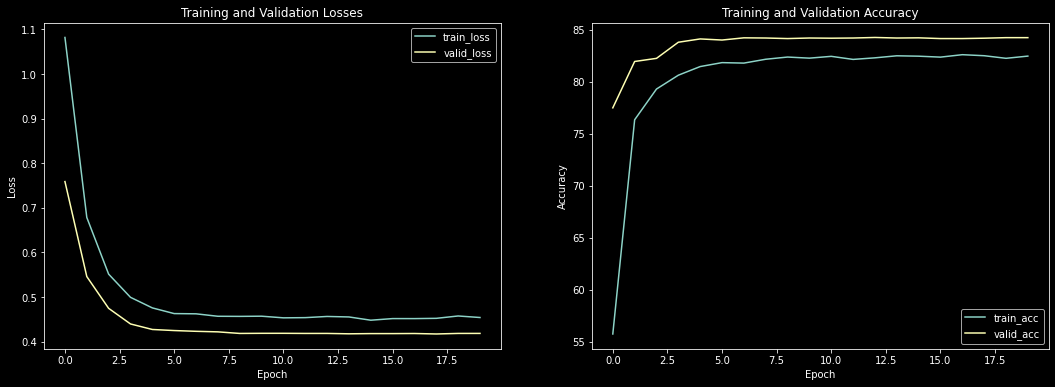

In [ ]:
from utils.model_analysis import plot_training_stat
figure = plot_training_stat(history)
figure.savefig('loss_accuracy_curves.png')

# Validation and Analysis

We load the best model weights and find 10 misclassified images for each of the classes. This will help us understand which classes are misclassified as which class.

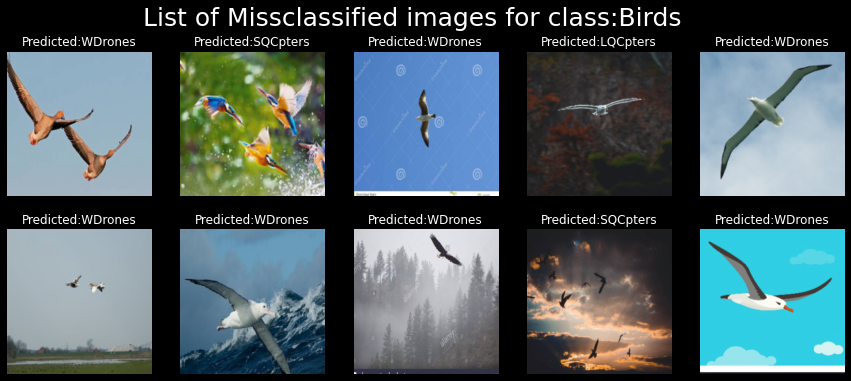

In [ ]:
from utils.model_analysis import plot_training_stat,plot_classwise_misclassified_Data
class_names = ['Birds','LQCpters','SQCpters','WDrones']
model.eval()
figure = plot_classwise_misclassified_Data(model,dataloader_valid,0,2,5,class_names)
figure.savefig('misclassified_birds.png')

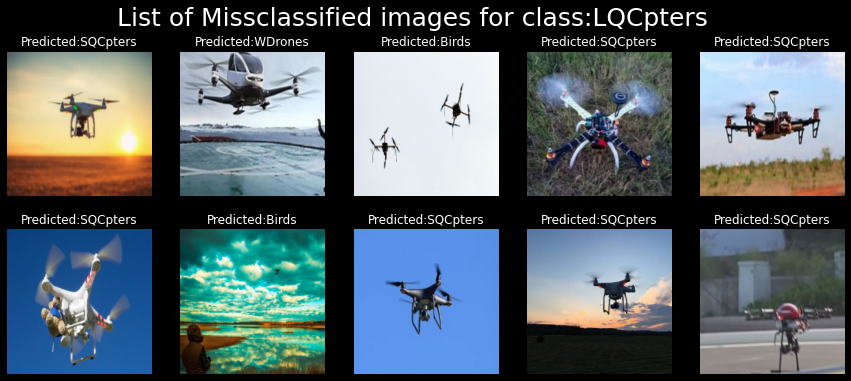

In [ ]:
figure = plot_classwise_misclassified_Data(model,dataloader_valid,1,2,5,class_names)
figure.savefig('misclassified_large_quadcopters.png')

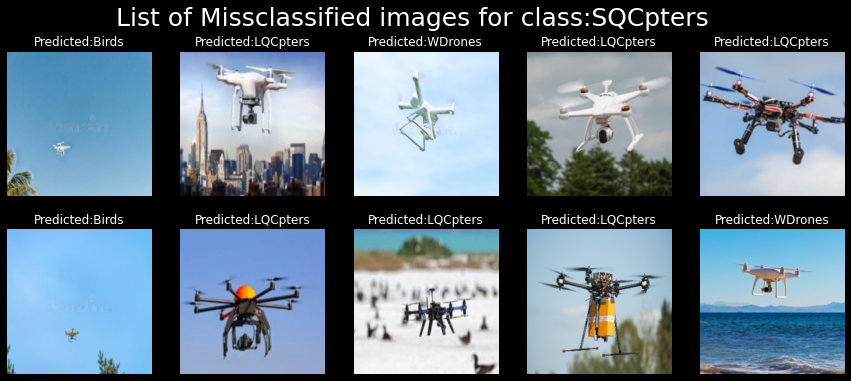

In [ ]:
figure = plot_classwise_misclassified_Data(model,dataloader_valid,2,2,5,class_names)
figure.savefig('misclassified_small_quadcopters.png')

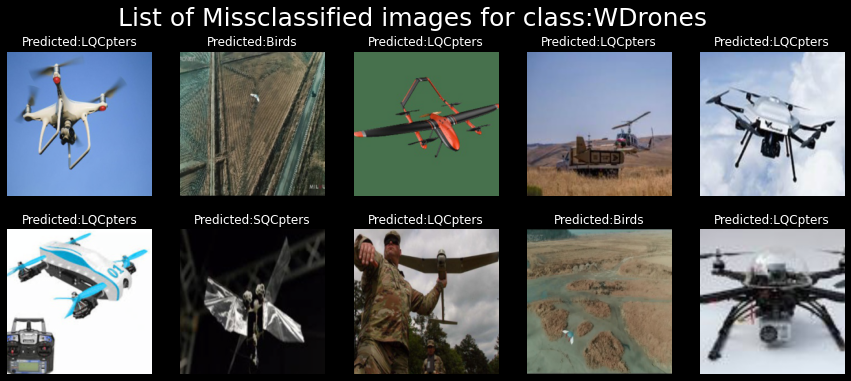

In [ ]:
figure = plot_classwise_misclassified_Data(model,dataloader_valid,3,2,5,class_names)
figure.savefig('misclassified_winged_drones.png')

In [ ]:
# Transfer model to cpu and save to be used with aws lambda
cpu_model = model.to('cpu')
traced_model = torch.jit.trace(cpu_model,torch.randn(1,3,224,224).to('cpu'))
traced_model.save("/content/jit_model_cpu.pt")